____

# Preparation

## Import library and set directory

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import linregress

import sys
sys.path.append('../src')
import benthic_mapping as bm

from datetime import datetime
from matplotlib import font_manager
from plotly.subplots import make_subplots

from rasterio.features import geometry_mask
from affine import Affine

# plt.style.use('dark_background')

In [2]:
# Define folder path
base_dir =  os.path.abspath(os.path.join(os.getcwd(), '../..'))
out_dir = os.path.join(base_dir, 'out')
data_sst_path = os.path.join(base_dir, 'data', 'raw', 'sst')
img_path = os.path.join(base_dir, 'docs', 'img')

output_path = os.path.join(out_dir, 'sst/processed_sst_2016_2023.nc')
shapefile_study_area = os.path.join(out_dir, 'geom_def/geom_study_area.shp')
shapefile_ground_truth = os.path.join(out_dir, 'geom_def', 'geom_ground_truth.shp')

name_file_sst = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_106.47E-106.62E_5.88S-5.72S_2016-01-01-2023-12-31.nc'

file_data_sst_path = os.path.join(
    data_sst_path, name_file_sst
)

## Pre-processing dataset

In [3]:
def concat_datasets(folder_path, output_file=None):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]
    
    if not files:
        raise ValueError("No NetCDF files found in the provided folder.")

    datasets = [xr.open_dataset(file, chunks={'time': 1}) for file in files]

    dataset = xr.concat(datasets, dim='time')

    dataset = dataset.sortby('time')

    if output_file:
        dataset.to_netcdf(output_file, engine='h5netcdf')

    return dataset

In [4]:
data_dir = os.path.join(out_dir, 'classification')
data = concat_datasets(data_dir)

# Masking

In [5]:
def masked_region(dataset, geodataframe, desired_year=None, target_epsg=32748):

    if geodataframe is None:
        raise ValueError("A GeoDataFrame must be provided.")

    if desired_year is not None:
        geodataframe['date'] = pd.to_datetime(geodataframe['date'])
        geodataframe['year'] = geodataframe['date'].dt.year
        geodataframe = geodataframe[geodataframe['year'] == desired_year]

        if geodataframe.empty:
            raise ValueError(f"No data found for the year {desired_year}. Please check your input.")

    if geodataframe.crs is None:
        raise ValueError("The GeoDataFrame must have a CRS defined.")
    if geodataframe.crs.to_epsg() != target_epsg:
        print(f"Converting geometry from EPSG:{geodataframe.crs.to_epsg()} to EPSG:{target_epsg}")
        geodataframe = geodataframe.to_crs(epsg=target_epsg)

    mask_shape = (len(dataset['y']), len(dataset['x']))

    transform = Affine.translation(dataset['x'].values[0], dataset['y'].values[0]) * \
                Affine.scale(dataset['x'].values[1] - dataset['x'].values[0], dataset['y'].values[1] - dataset['y'].values[0])

    mask = geometry_mask(geodataframe['geometry'], out_shape=mask_shape, transform=transform, all_touched=True, invert=True)

    mask_dataarray = xr.DataArray(mask.astype(bool), dims=('y', 'x'))

    masked_dataset = dataset.where(mask_dataarray)

    xmin, ymin, xmax, ymax = geodataframe.total_bounds

    if not (xmin >= dataset.x.min() and xmax <= dataset.x.max() and ymin >= dataset.y.min() and ymax <= dataset.y.max()):
        raise ValueError("Bounding box from GeoDataFrame exceeds dataset bounds.")

    masked_dataset = masked_dataset.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))    

    if 'time' in masked_dataset.dims:
        masked_dataset = masked_dataset.sortby('time')
    
    return masked_dataset

In [6]:
gdf = gpd.read_file(shapefile_study_area)

da = masked_region(
    data['predictions'], gdf
)

# Calculate Areas

In [7]:
def calculate_coverage_area(data, variable_name=None, value=None):
 
    if isinstance(data, xr.Dataset):
        if variable_name is None:
            raise ValueError("variable_name must be provided for xarray.Dataset")
        variable_data = data[variable_name]
    elif isinstance(data, xr.DataArray):
        variable_data = data
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    res_x = np.abs(data['x'][1] - data['x'][0])
    res_y = np.abs(data['y'][1] - data['y'][0])
    pixel_area = res_x * res_y

    condition = (variable_data == value)
    
    total_area = (condition * pixel_area).sum(dim=['y', 'x'])

    total_area_ha = total_area / 10000.0
    
    return total_area_ha

In [8]:
column_names = {
    1: 'denseSeagrass', 2: 'sparseSeagrass', 
    3: 'coralRubble', 4: 'sand'
}

area_dict = {
    'year': [], 'denseSeagrass': [], 'sparseSeagrass': [],
    'coralRubble': [], 'sand': [], 'total_area': []
}

for value, column_name in column_names.items():
    area_per_time = calculate_coverage_area(da, variable_name=None, value=value)
    area_dict[column_name] = area_per_time.values
    area_dict['year'] = pd.to_datetime(da['time'].values).year

area_dict['total_area'] = np.sum([area_dict[name] for name in column_names.values()], axis=0)

df = pd.DataFrame(area_dict).sort_values(by='year')

df_percentage = df[['denseSeagrass', 'sparseSeagrass', 'coralRubble', 'sand']].div(df['total_area'], axis=0) * 100
df_percentage.set_index(df['year'], inplace=True)

In [30]:

# Create subplots with shared x-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add stacked bar plot for percentages
colors = ['#508D69', '#9ADE7B', '#FF6464', '#FFE162']
for col, color in zip(df_percentage.columns, colors):
    fig.add_trace(
        go.Bar(
            x=df['year'],
            y=df_percentage[col],
            name=col,
            marker_color=color,
            text=df[col],
            textposition='inside',
            texttemplate='%{text:.2f} ha',
            textfont =dict(
                family='Lato',
                color='black',
                weight="bold"
            )
        ),
        secondary_y=False
    )

# Update layout
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=df['year'],
        ticktext=df['year'],
        showline=True,
        linecolor='rgb(0, 0, 0)',
        linewidth=2,
        ticks='outside',
        tickcolor='rgb(0, 0, 0)',
        tickfont=dict(
            family='Lato',
            size=16,
            color='rgb(0, 0, 0)'
        )
    ),
    yaxis=dict(
        title='Percentage (%)',
        titlefont=dict(
            family='Lato',
            size=16,
            color='black'
        ),
        zeroline=False,
        ticks='outside',
        tickcolor='black',
        tickfont=dict(
            family='Lato',
            size=16,
            color='black'
        )
    ),
    plot_bgcolor='white',
    height=600,
    width=1000,
    barmode='stack'
)

# Add legend
fig.update_layout(
    legend=dict(
        x=0.5,
        y=-0.1,
        xanchor='center',
        yanchor='top',
        orientation='h',
        traceorder='normal',
        font=dict(
            family='Lato',
            size=16,
            color='black'
        )
    )
)

# Display the plot
fig.show()

# Save the figure as a PNG file
fig.write_image(os.path.join(img_path, 'coverage_area_percentage.png'), engine="kaleido", scale=6)

# SST and denseSeagrass

## Open and Prepare Datasets

In [49]:
def prepare_sst(file_path, var_name):
    dataset = xr.open_dataset(file_path)
    
    valid_min = dataset[var_name].attrs['valid_min']
    valid_max = dataset[var_name].attrs['valid_max']
    dataset[var_name] = dataset[var_name].where(
        (dataset[var_name] >= valid_min) & (dataset[var_name] <= valid_max) , np.nan
    )
    
    dataset[var_name] = dataset[var_name] - 273.15
    dataset[var_name].attrs['units'] = 'Celcius'
    
    dataset = dataset.resample(time='YE').mean()
    
    return dataset.rio.write_crs("EPSG:4326", inplace=True).rio.reproject("EPSG:32748")

### Prepare and Clip Dataset

In [50]:
sst_data = prepare_sst(file_data_sst_path, 'analysed_sst')

sst_da = sst_data['analysed_sst'].rio.clip(
    gdf.geometry, gdf.crs, all_touched=True, invert=False
)
mean_sst = sst_da.mean(dim=['x', 'y'])

total_areas = calculate_coverage_area(
    da, variable_name=None, value=1
)

## Plot both dataset

In [71]:
df_area = pd.DataFrame({
    'year': pd.to_datetime(total_areas['time'].values).year,
    'total_area': total_areas.values
})

df_area = df_area.sort_values(by='year')# Assuming your DataArray is named 'total_area'
df_sst = pd.DataFrame({
    'year': pd.to_datetime(mean_sst['time'].values).year,
    'degC': mean_sst.values.flatten().round(2)
})

df_sst = df_sst.sort_values(by='year')
df = pd.merge(df_sst, df_area, on='year')

slope, intercept, r_value, p_value, std_err = linregress(df['year'], df['total_area'])
df['trend_line'] = intercept + slope * df['year']

In [54]:
# Create subplots with shared x-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar plot for total area on the left y-axis
fig.add_trace(
    go.Bar(
        x=df['year'], 
        y=df['total_area'], 
        name='Coverage Area (ha)', 
        marker_color='blue', 
        opacity=0.7
    ),
    secondary_y=False,
)

# Add trend line for total area on the left y-axis
fig.add_trace(
    go.Scatter(
        x=df['year'],
        y=df['trend_line'],
        name=f'Trend Line; Slope: {slope:.2f} ha/year',
        mode='lines',
        line=dict(color='black', dash='dash')
    ),
    secondary_y=False,
)

# Add line plot for temperature on the right y-axis
fig.add_trace(
    go.Scatter(
        x=df['year'], 
        y=df['degC'], 
        name='Sea Surface Temperature (°C)', 
        mode='lines',
        line=dict(color='red', width=2)
    ),
    secondary_y=True,
)

# Create axis objects
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=df['year'],
        ticktext=df['year'],
        showline=True,
        linecolor='rgb(0, 0, 0)',
        linewidth=2,
        ticks='outside',
        tickcolor='rgb(0, 0, 0)',
        tickfont=dict(
            family='Lato',
            size=18,
            color='rgb(0, 0, 0)'
        )
    ),
    yaxis=dict(
        title='Coverage Area (ha)',
        titlefont=dict(
            family='Lato',
            size=18,
            color='blue'
        ),
        zeroline=False,
        ticks='outside',
        tickcolor='blue',
        tickfont=dict(
            family='Lato',
            size=18,
            color='blue'
        ),
        tick0=0, 
        dtick=4
    ),
    yaxis2=dict(
        title='Annual Sea Surface Temperature (°C)',
        titlefont=dict(
            family='Lato',
            size=18,
            color='red'
        ),
        overlaying='y',
        side='right',
        zeroline=False,
        ticks='outside',
        tickcolor='red',
        tickfont=dict(
            family='Lato',
            size=18,
            color='red'
        )
    ),
    plot_bgcolor='white',
    height=600,
    width=1000
)

# Add legend
fig.update_layout(
    legend=dict(
        x=0.675,
        y=1,
        traceorder='normal',
        font=dict(
            family='Lato',
            size=16,
            color='black'
        )
    )
)

# Display the plot
fig.show()

# Save the figure as a PNG file
fig.write_image(os.path.join(img_path, 'coverage_sst.png'), engine="kaleido", scale=6)

In [41]:
correlation = df['degC'].corr(df['total_area'])
print(f'Correlation coefficient: {correlation}')

Correlation coefficient: -0.4323960008209777


# Climate Variables

## ONI

In [86]:
climate_vars_path = os.path.join(base_dir, 'data', 'raw', 'climate_variables')
oni_file = os.path.join(climate_vars_path, 'ONI_2016_2023.csv')
df = pd.read_csv(oni_file)

In [87]:
# Melt the dataframe to long format
df_long = df.melt(id_vars=['Year'], var_name='Period', value_name='Value')

# Define the desired periods
desired_periods = ['DJF', 'FMA', 'AMJ', 'JJA', 'ASO', 'OND']

# Create a new datetime column based on Year and Period
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Period'].map(
    {'DJF': '01', 'JFM': '02', 'FMA': '03', 'MAM': '04', 'AMJ': '05', 'MJJ': '06',
     'JJA': '07', 'JAS': '08', 'ASO': '09', 'SON': '10', 'OND': '11', 'NDJ': '12'}))

# Filter to keep only the desired periods
df_filtered = df_long[df_long['Period'].isin(desired_periods)]

# Sort by Date
df_filtered = df_filtered.sort_values('Date')

# Assign colors based on Value
colors = ['red' if value > 0 else 'blue' for value in df_filtered['Value']]

# Font styles
title_font_style = dict(
    family='Lato',
    color='black',
    size=24
)

font_style = dict(
    family='Lato',
    color='black',
    size=14
)

# Plotting with Plotly
fig = go.Figure()

# Adding bar trace
fig.add_trace(
    go.Bar(
        x=df_filtered['Date'],
        y=df_filtered['Value'],
        marker_color=colors
    )
)

# Customizing the layout
fig.update_layout(
    xaxis=dict(
        title='Periods',
        tickmode='array',
        tickvals=df_filtered['Date'], 
        ticktext=df_filtered['Period'],
        titlefont=title_font_style,
        tickfont=font_style,
        tickangle=-45,
        showline=True,
        linecolor='black',
        linewidth=2,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Oceanic Niño Index',
        titlefont=title_font_style,
        tickfont=font_style,
        dtick=.25,
        gridcolor='lightgray'
    ),
    showlegend=False,
    plot_bgcolor='white',
    height=600,
    width=1000
)

# Add annotation to the top-left corner
fig.add_annotation(
    text="(a)",
    xref="paper", yref="paper",
    x=-.05, y=1.1,
    xanchor="left", yanchor="top",
    showarrow=False,
    font=dict(
        family='Lato',
        color='black',
        weight='bold',
        size=24
    )
)

# Add annotations for years and horizontal extents
for year in df_filtered['Year'].unique():
    # Get the corresponding dates for the year
    year_dates = df_filtered[df_filtered['Year'] == year]['Date']
    start_date = year_dates.min()
    end_date = year_dates.max()
    mid_date = year_dates.mean()

    # Add annotation for year label
    fig.add_annotation(
        x=mid_date,
        y=min(df_filtered['Value']) - 0.3,
        text=str(year),
        showarrow=False,
        font=font_style,
        bgcolor='white',
    )

    # Add a horizontal extent line
    fig.add_shape(
        type="line",
        x0=start_date,
        x1=end_date,
        y0=min(df_filtered['Value']) - 0.3,
        y1=min(df_filtered['Value']) - 0.3,
        line=dict(
            color="black",
            width=1,
            dash='dot'
        )
    )

# Show the figure
fig.show()

# Save the figure as a PNG file
fig.write_image(os.path.join(img_path, 'oni.png'), engine="kaleido", scale=6)

## IOD

In [77]:
climate_vars_path = os.path.join(base_dir, 'data', 'raw', 'climate_variables')
iod_file = os.path.join(climate_vars_path, 'IOD_2016_2023.csv')
df = pd.read_csv(iod_file)

In [78]:
# Define the desired periods and calculate the mean for each period
df['DJF'] = df[['Dec', 'Jan', 'Feb']].mean(axis=1)
df['FMA'] = df[['Feb', 'Mar', 'Apr']].mean(axis=1)
df['AMJ'] = df[['Apr', 'May', 'Jun']].mean(axis=1)
df['JJA'] = df[['Jun', 'Jul', 'Aug']].mean(axis=1)
df['ASO'] = df[['Aug', 'Sep', 'Oct']].mean(axis=1)
df['OND'] = df[['Oct', 'Nov', 'Dec']].mean(axis=1)

# Melt the dataframe to long format
df_long = df.melt(id_vars=['Year'], value_vars=['DJF', 'FMA', 'AMJ', 'JJA', 'ASO', 'OND'],
                  var_name='Period', value_name='Value')

# Create a new datetime column based on Year and Period
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Period'].map(
    {'DJF': '01', 'FMA': '03', 'AMJ': '05', 'JJA': '07', 'ASO': '09', 'OND': '11'}
))

# Sort by Date
df_filtered = df_long.sort_values('Date')

# Assign colors based on Value
colors = ['red' if value > 0 else 'blue' for value in df_filtered['Value']]

# Font styles
title_font_style = dict(
    family='Lato',
    color='black',
    size=24
)

font_style = dict(
    family='Lato',
    color='black',
    size=14
)

# Plotting with Plotly
fig = go.Figure()

# Adding bar trace
fig.add_trace(
    go.Bar(
        x=df_filtered['Date'],
        y=df_filtered['Value'],
        marker_color=colors
    )
)

# Customizing the layout
fig.update_layout(
    xaxis=dict(
        title='Periods',
        tickmode='array',
        tickvals=df_filtered['Date'], 
        ticktext=df_filtered['Period'],
        titlefont=title_font_style,
        tickfont=font_style,
        tickangle=-45,
        showline=True,
        linecolor='black',
        linewidth=2,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Dipole Mode Index',
        titlefont=title_font_style,
        tickfont=font_style,
        dtick=0.25,
        gridcolor='lightgray'
    ),
    showlegend=False,
    plot_bgcolor='white',
    height=600,
    width=1000
)

# Add annotation to the top-left corner
fig.add_annotation(
    text="(b)",
    xref="paper", yref="paper",
    x=-.05, y=1.1,
    xanchor="left", yanchor="top",
    showarrow=False,
    font=dict(
        family='Lato',
        color='black',
        weight='bold',
        size=24
    )
)

# Add annotations for years and horizontal extents
for year in df_filtered['Year'].unique():
    # Get the corresponding dates for the year
    year_dates = df_filtered[df_filtered['Year'] == year]['Date']
    start_date = year_dates.min()
    end_date = year_dates.max()
    mid_date = year_dates.mean()

    # Add annotation for year label
    fig.add_annotation(
        x=mid_date,
        y=min(df_filtered['Value']) - 0.05,
        text=str(year),
        showarrow=False,
        font=font_style,
        bgcolor='white',
    )

    # Add a horizontal extent line
    fig.add_shape(
        type="line",
        x0=start_date,
        x1=end_date,
        y0=min(df_filtered['Value'])- 0.05,
        y1=min(df_filtered['Value'])- 0.05,
        line=dict(
            color="black",
            width=1,
            dash='dot'
        )
    )

# Show the figure
fig.show()

# Save the figure as a PNG file
fig.write_image(os.path.join(img_path, 'dmi_standard.png'), engine="kaleido", scale=6)

# Ground Truth Validation

In [19]:
gdf = gpd.read_file(shapefile_ground_truth)

class_map = {'Lamun': 1, 'Terumbu': 2, 'Pasir': 3}
gdf['Class'] = gdf['Class_Objc'].map(class_map)

gdf = gdf[['Name', 'ID', 'Class_Objc', 'Class', 'geometry']]

In [21]:
def reclassify(data_array):
    """_summary_

    Args:
        data_array (_type_): _description_

    Returns:
        _type_: _description_
    """
    np_array = data_array.values

    np_array = np.copy(np_array)  # Create a copy to avoid modifying the original data
    np_array[np.isnan(np_array)] = np.nan  # Preserve NaN values
    np_array[np_array == 1] = 1
    np_array[np_array == 2] = 1
    np_array[np_array == 3] = 2
    np_array[np_array == 4] = 3

    return xr.DataArray(
        np_array, dims=data_array.dims, coords=data_array.coords, attrs=data_array.attrs
    )

In [22]:
ds = da.isel(time=6).to_dataset()
ds = ds[['y', 'x', 'predictions']]

ground_point = bm.labeled_samples(ds, gdf,'Class')

ground_point['predictions'] = reclassify(ground_point['predictions'])

y_pred = ground_point['predictions'].values.flatten()
y_true = ground_point['label'].values.flatten()

mask = ~np.isnan(y_pred) & ~np.isnan(y_true)

y_pred = y_pred[mask]
y_true = y_true[mask]

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

print(classification_report(y_true, y_pred))
print(f"{confusion_matrix(y_true, y_pred)}\n")
print(f"accuracy score:{accuracy_score(y_true, y_pred)}")
print(f"cohen's kappa:{cohen_kappa_score(y_true, y_pred)}")

              precision    recall  f1-score   support

         1.0       0.88      0.76      0.81        29
         2.0       0.54      0.93      0.68        27
         3.0       0.87      0.43      0.58        30

    accuracy                           0.70        86
   macro avg       0.76      0.71      0.69        86
weighted avg       0.77      0.70      0.69        86

[[22  6  1]
 [ 1 25  1]
 [ 2 15 13]]

accuracy score:0.6976744186046512
cohen's kappa:0.5509138381201044


# Relative Surface Reflectance

In [79]:
df = data[
    ['blue', 'green', 'red', 'red_edge', 'nir', 'swir1', 'swir2','predictions']
    ].to_dask_dataframe()

df = df.reset_index().dropna(subset=['predictions']).drop(
    columns=['index', 'y', 'x', 'transverse_mercator']
)

df['predictions'] = df['predictions'].astype(int)

agg_df = (
    df.groupby(['time', 'predictions'])
    .agg(['mean', 'std'])
    .reset_index()
)

agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]

agg_df['year'] = agg_df['time'].dt.year

In [80]:
# Separate mean and std columns
mean_cols = [col for col in agg_df.columns if 'mean' in col and col not in ['time_mean', 'year_mean']]
std_cols = [col for col in agg_df.columns if 'std' in col and col not in ['time_std', 'year_std']]

# Exclude 'time' and 'year' from the mean_df for both mean and std data
mean_df = agg_df[['predictions'] + mean_cols].groupby('predictions').mean().reset_index().compute()
std_df = agg_df[['predictions'] + std_cols].groupby('predictions').mean().reset_index().compute()

# Optionally, if you need both mean and std in a single DataFrame
combined_df = mean_df.merge(std_df, on='predictions', suffixes=('_mean', '_std'))

In [85]:
# Font styles
title_font_style = dict(
    family='Lato',
    color='black',
    size=18
)

font_style = dict(
    family='Lato',
    color='black',
    size=14
)

color_map = {
    1: '#508D69',
    2: '#9ADE7B',
    3: '#FF6464',
    4: '#FFE162'
}

labels = {
    1: 'Dense Seagrass', 
    2: 'Sparse Seagrass', 
    3: 'Coral Rubble', 
    4: 'Sand'
}

# Plot for Mean Reflectance Profiles
fig_mean = go.Figure()

for class_level in mean_df['predictions'].unique():
    data_class_mean = mean_df[mean_df['predictions'] == class_level]
    fig_mean.add_trace(
        go.Scatter(
            x=['blue', 'green', 'red', 'red_edge', 'nir', 'swir1', 'swir2'],
            y=[
                data_class_mean['blue_mean'].values[0],
                data_class_mean['green_mean'].values[0],
                data_class_mean['red_mean'].values[0],
                data_class_mean['red_edge_mean'].values[0],
                data_class_mean['nir_mean'].values[0],
                data_class_mean['swir1_mean'].values[0],
                data_class_mean['swir2_mean'].values[0]
            ],
            mode='markers+lines',
            name=labels.get(class_level, "Unknown Class"),
            line=dict(color=color_map.get(class_level, 'black')),
            marker=dict(color=color_map.get(class_level, 'black'))
        )
    )

# Add annotation (a) for Mean Plot
fig_mean.add_annotation(
    text="(a)",
    xref="paper", yref="paper",
    x=-0.15, y=1.2,
    xanchor="left", yanchor="top",
    showarrow=False,
    font=dict(
        family='Lato',
        color='black',
        weight='bold',
        size=24
    )
)

# Update layout for Mean Plot
fig_mean.update_layout(
    xaxis=dict(
        title='Bands',
        titlefont=title_font_style,
        tickfont=font_style
    ),
    yaxis=dict(
        title='Reflectance',
        titlefont=title_font_style,
        tickfont=font_style
    ),
    legend_title='Label',
    legend=dict(
        x=0.7,
        y=1,
        traceorder='normal',
        font=font_style
    ),
    template='simple_white',
    height=600,
    width=600
)

fig_mean.show()

# Save Mean Plot
fig_mean.write_image(
    os.path.join(img_path, 'reflectance_profiles_mean.png'), 
    engine="kaleido", scale=6
)


# Plot for Standard Deviation Reflectance Profiles
fig_std = go.Figure()

for class_level in std_df['predictions'].unique():
    data_class_std = std_df[std_df['predictions'] == class_level]
    fig_std.add_trace(
        go.Scatter(
            x=['blue', 'green', 'red', 'red_edge', 'nir', 'swir1', 'swir2'],
            y=[
                data_class_std['blue_std'].values[0],
                data_class_std['green_std'].values[0],
                data_class_std['red_std'].values[0],
                data_class_std['red_edge_std'].values[0],
                data_class_std['nir_std'].values[0],
                data_class_std['swir1_std'].values[0],
                data_class_std['swir2_std'].values[0]
            ],
            mode='markers+lines',
            name=labels.get(class_level, "Unknown Class"),
            line=dict(color=color_map.get(class_level, 'black')),
            marker=dict(color=color_map.get(class_level, 'black'))
        )
    )

# Add annotation (b) for Std Plot
fig_std.add_annotation(
    text="(b)",
    xref="paper", yref="paper",
    x=-0.15, y=1.2,
    xanchor="left", yanchor="top",
    showarrow=False,
    font=dict(
        family='Lato',
        color='black',
        weight='bold',
        size=24
    )
)

# Update layout for Std Plot
fig_std.update_layout(
    xaxis=dict(
        title='Bands',
        titlefont=title_font_style,
        tickfont=font_style
    ),
    yaxis=dict(
        title='Reflectance',
        titlefont=title_font_style,
        tickfont=font_style
    ),
    legend_title='Label',
    legend=dict(
        x=0.7,
        y=1,
        traceorder='normal',
        font=font_style
    ),
    template='simple_white',
    height=600,
    width=600
)

fig_std.show()

# Save Std Plot
fig_std.write_image(
    os.path.join(img_path, 'reflectance_profiles_std.png'), 
    engine="kaleido", scale=6
)

# Plot the Predicted

In [15]:
def plot_time_series(dataset, data_variable, output_dir, font_family='Lato'):
    font_properties = font_manager.FontProperties(
        family=font_family
    )
    
    labels = ['denseSeagrass', 'sparseSeagrass', 'coralRubble', 'sand']
    colors = ['#508D69', '#9ADE7B', '#FF6464', '#FFE162']
    cmap = mcolors.ListedColormap(colors)
    bounds = [1.0, 2.0, 3.0, 4.0, 5.0]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    proj = ccrs.UTM(zone=50, southern_hemisphere=True)
      
    for i in range(len(dataset[data_variable].time)):
        plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=proj)
        
        selected_data = dataset[data_variable].isel(time=i)
        selected_data.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, transform=proj)
        
        ax.set_aspect('equal', adjustable='datalim')
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)
        
        ax.set_aspect('equal', adjustable='datalim')
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)

        ax.set_title('')
        year = selected_data.time.dt.year.values
        annotation_text = f'{year}'

        ax.annotate(annotation_text, xy=(0.02, 0.98), xycoords='axes fraction', fontsize=16,
                    ha='left', va='top', font_properties = font_properties)

        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                            markersize=15, markerfacecolor=color)
                for label, color in zip(labels, colors)]

        ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.005),
                            ncol=len(labels), frameon=False, prop = font_properties)
        
        plt.tick_params(
            labelfontfamily=font_family, grid_alpha=0.5
        )
        
        plt.grid(True)
        
        plt.savefig(
            f'{output_dir}/benthic_classification_{year}.png',
            dpi=300, bbox_inches='tight'
        )
        plt.close()

In [16]:
ds = da.to_dataset()
ds = ds[['y', 'x', 'predictions']]

plot_time_series(ds, 'predictions', img_path)

# Changes

In [39]:
def classify_changes_per_year(dataset):
    """_summary_

    Args:
        dataset (_type_): _description_

    Returns:
        _type_: _description_
    """
    class_data = dataset['predictions'].values

    coords = {
        'x': dataset['x'].values,
        'y': dataset['y'].values,
        'time': dataset['time'].values
    }
    
    change_maps = {}
    
    change_categories = {
        (2, 1): 1,  # sparseSeagrass to denseSeagrass (density gain)
        (2, 2): 2,  # unchanged (consistent seagrass)
        (2, 3): 3,  # sparseSeagrass to coralRubble (loss)
        (2, 4): 3,  # sparseSeagrass to sand (loss)
        (3, 2): 4,  # coralRubble to sparseSeagrass (gain)
        (4, 2): 4,  # sand to sparseSeagrass (gain)
        (4, 4): 0,  # sand remains sand (absence)
        (3, 3): 0,  # coralRubble remains coralRubble (absence)
    }

    for i in range(1, len(dataset['time'])):
        prev_class = class_data[i-1, :, :]
        curr_class = class_data[i, :, :]

        change_map = np.full(prev_class.shape, np.nan)

        for (prev, curr), value in change_categories.items():
            change_map[(prev_class == prev) & (curr_class == curr)] = value
        
        year_pair = f"{str(dataset['time'][i-1].values)[:4]}_{str(dataset['time'][i].values)[:4]}"
        change_maps[year_pair] = change_map

    changes_data = {
        year_pair: (['y', 'x'], change_map) for year_pair, change_map in change_maps.items()
    }
   
    return xr.Dataset(
        data_vars=changes_data,
        coords={
            'x': ('x', coords['x']),
            'y': ('y', coords['y'])
        }
    )

In [40]:
ds = da.to_dataset()
ds = ds[['y', 'x', 'predictions']]

changes_ds = classify_changes_per_year(ds)

In [43]:
def plot_changes(dataset, output_dir, font_family='Lato'):
    """_summary_

    Args:
        dataset (_type_): _description_
        output_dir (_type_): _description_
        font_family (str, optional): _description_. Defaults to 'Lato'.
    """
    font_properties = font_manager.FontProperties(family=font_family)

    labels = ['Consistent Absence', 'Density Gain', 'Consistent Seagrass', 
              'Loss', 'Gain']
    colors = ['#B4B4B8', '#508D69', '#D2DE32', '#FF6464', '#9ADE7B']
    cmap = mcolors.ListedColormap(colors)
    bounds = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    proj = ccrs.UTM(zone=50, southern_hemisphere=True)

    # Loop over each data variable in the dataset
    for var_name in dataset.data_vars:
        # Create the figure and axes
        plt.figure(figsize=(10, 8))
        ax = plt.axes(projection=proj)

        # Select data for plotting
        selected_data = dataset[var_name]

        # Plot the selected data with the defined colormap and normalization
        selected_data.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, transform=proj)

        # Extract the variable names for annotation
        variable_names = var_name.split('_')

        # Set equal aspect ratio for the plot
        ax.set_aspect('equal', adjustable='datalim')

        # Remove the title from the plot
        ax.set_title('')

        # Add annotation to the plot
        ax.annotate(f'Changes from {variable_names[0]} to {variable_names[1]}', xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12,
                    ha='left', va='top', font_properties=font_properties)

        # Create legend with custom labels and colors
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markersize=15, markerfacecolor=color)
                   for label, color in zip(labels, colors)]

        # Add legend to the plot with specified properties
        legend = ax.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.005),
                            ncol=len(labels), frameon=False, prop=font_properties)

        # Save the plot to the specified directory with the variable name in the filename
        plt.savefig(f'{output_dir}/changes_{var_name}.png', dpi=300, bbox_inches='tight')

        # Close the plot to avoid overlapping in the loop
        plt.close()

In [45]:
plot_changes(changes_ds, img_path)  

In [76]:
changes_ds

<xarray.Dataset> Size: 28MB
Dimensions:    (y: 568, x: 885)
Coordinates:
  * x          (x) float64 7kB 6.716e+05 6.716e+05 ... 6.805e+05 6.805e+05
  * y          (y) float64 5kB 9.369e+06 9.369e+06 ... 9.363e+06 9.363e+06
Data variables:
    2016_2017  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2017_2018  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2018_2019  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2019_2020  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2020_2021  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2021_2022  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan
    2022_2023  (y, x) float64 4MB nan nan nan nan nan ... nan nan nan nan nan

In [103]:
# Initialize a list to store distributions
distribution_list = []

# Get the names of coordinate variables
coord_vars = changes_ds.coords.keys()

# Loop through each variable in the changes_ds dataset
for var_name in changes_ds.variables:
    # Skip coordinate variables
    if var_name in coord_vars:
        continue
    
    # Get the unique values and their counts
    unique_values, counts = np.unique(changes_ds[var_name].values, return_counts=True)
    
    # Append to the distribution list as a DataFrame
    for value, count in zip(unique_values, counts):
        distribution_list.append({'Variable': var_name, 'Value': value, 'Count': count})

# Create a DataFrame from the distribution list
distribution_df = pd.DataFrame(distribution_list)

pivot_df = distribution_df.pivot(index='Value', columns='Variable', values='Count')



# # Rename the columns for better clarity (optional)
# pivot_df.columns.name = None  # Remove the name of the columns
# pivot_df.columns = ['Value'] + list(pivot_df.columns[1:])  # Keeping the first column as 'Value'

# Display the transformed DataFrame
pivot_df.reset_index()

Variable,Value,2016_2017,2017_2018,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023
0,NaN,428339,427681,424874,424130,428653,427800,424290
1,0.0,48390,53496,55429,57118,53334,52875,57138
2,1.0,2242,788,517,686,457,271,1678
3,2.0,11404,9434,11297,12007,11829,12665,11528
4,3.0,7175,7166,3676,6006,3107,5632,4088
5,4.0,5130,4115,6887,2733,5300,3437,3958


In [108]:
# Define pixel resolution in meters (assuming you have a known resolution)
pixel_width = abs(changes_ds.x.values[1] - changes_ds.x.values[0])  # x dimension resolution
pixel_height = abs(changes_ds.y.values[1] - changes_ds.y.values[0])  # y dimension resolution
pixel_area = pixel_width * pixel_height  # area in square meters

# Initialize a dictionary to hold areas in hectares for each variable
areas_ha = {}

# Loop through each variable and calculate areas
for var in changes_ds.data_vars:
    # Count occurrences of each unique value (NaN, 0, 1, 2, 3, 4)
    counts = changes_ds[var].values
    unique, counts = np.unique(counts[~np.isnan(counts)], return_counts=True)  # Exclude NaNs

    # Create a dictionary to store areas
    areas = {}
    for value, count in zip(unique, counts):
        areas[value] = count * pixel_area / 10000  # Convert to hectares

    # Store the areas dictionary in areas_ha
    areas_ha[var] = areas
    
# Create a DataFrame from the areas_ha dictionary
area_df = pd.DataFrame.from_dict(areas_ha, orient='index') #.fillna(0)  # Fill NaNs with 0 for better visualization

# Map the columns using the column_names dictionary
area_df = area_df.rename(columns={0: 'Consistent Absence',
                                   1: 'Density Gain',
                                   2: 'Consistent Seagrass',
                                   3: 'Loss',
                                   4: 'Gain'}).reset_index()

# Melt the DataFrame to have 'index' and 'Category' as columns
melted_df = area_df.melt(id_vars='index', var_name='Category', value_name='Area')

# Pivot the melted DataFrame to have years as columns
pivoted_df = melted_df.pivot(index='Category', columns='index', values='Area')

# Add Net Change calculation
pivoted_df.loc['Net Change'] = pivoted_df.loc['Gain'] - pivoted_df.loc['Loss']

# Display the pivoted DataFrame
pivoted_df = pivoted_df.reset_index()
pivoted_df

index,Category,2016_2017,2017_2018,2018_2019,2019_2020,2020_2021,2021_2022,2022_2023
0,Consistent Absence,483.90,534.96,554.29,571.18,533.34,528.75,571.38
1,Consistent Seagrass,114.04,94.34,112.97,120.07,118.29,126.65,115.28
2,Density Gain,22.42,7.88,5.17,6.86,4.57,2.71,16.78
3,Gain,51.30,41.15,68.87,27.33,53.00,34.37,39.58
4,Loss,71.75,71.66,36.76,60.06,31.07,56.32,40.88
5,Net Change,-20.45,-30.51,32.11,-32.73,21.93,-21.95,-1.30


# Plot All Data Vars

In [31]:
gdf = gpd.read_file(shapefile_study_area)

ds = masked_region(
    data, gdf
)

In [32]:
def plot_all_variables(dataset, output_dir):
    
    for i in range(len(dataset.time)):
        time_step = dataset.time[i].values
        
        time_str = pd.to_datetime(time_step).strftime("%Y%m%d")

        for var in dataset.data_vars:
            data = dataset[var].sel(time=time_step)
            
            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.UTM(zone=50, southern_hemisphere=True)})
            ax.set_aspect('equal', adjustable='datalim')

            data.plot(ax=ax, robust=True)
            
            ax.set_title(f'{var.upper()} at {time_str}')

            filename = f'{output_dir}/{var.upper()}_{time_str}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            
            plt.close(fig)

In [33]:
vars_img_path = os.path.join(img_path, 'vars_img')
plot_all_variables(ds, vars_img_path)

# Feature Importance

In [351]:
feature_importance_file_path = os.path.join(out_dir, 'csv','feature_important.csv')
data = pd.read_csv(feature_importance_file_path)

In [352]:
pivot_data = data.pivot(index='Years', columns='Features', values='Importance')

In [ ]:
# 2. Year-wise Comparison
top_features_each_year = pivot_data.apply(lambda x: x.nlargest(5).index.tolist(), axis=1)
top_features_each_year

Years
2016         [red_edge_sg, awei, green_sg, red_sg, green]
2017    [red_edge_sg, red_edge, red, ngrdi_red, green_sg]
2018           [red, swir1, red_edge, green, red_edge_sg]
2019         [red_edge, red_edge_sg, red, blue_sg, swir1]
2020         [red, red_edge, red_edge_sg, nir, ngrdi_red]
2021          [red, red_edge, blue, blue_sg, red_edge_sg]
2022        [red, red_edge, mndwi, red_edge_sg, green_sg]
2023              [red, red_edge, blue, nir, red_edge_sg]
dtype: object

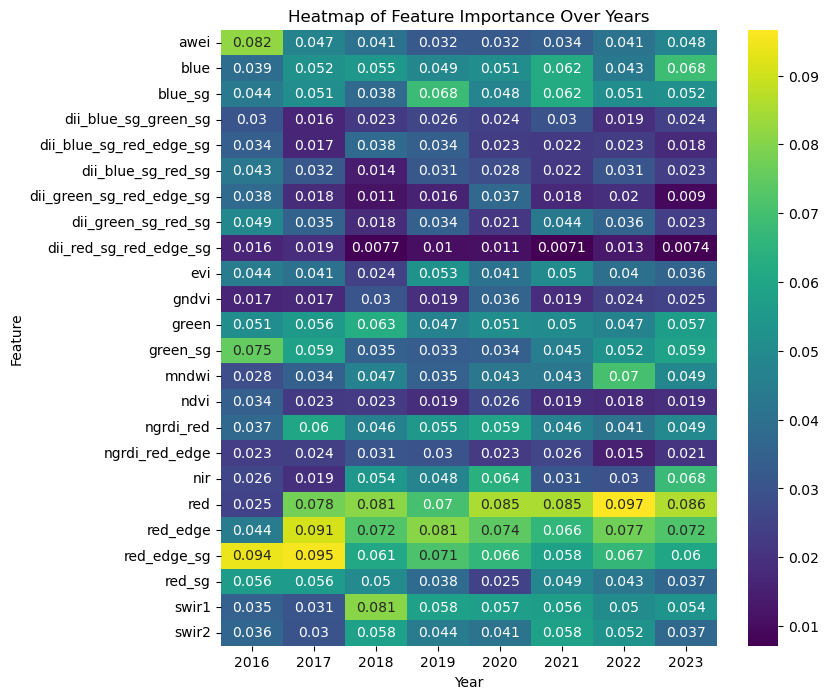

In [ ]:
import seaborn as sns

# Transpose the pivot_data if necessary, to have years on the x-axis
pivot_data_transposed = pivot_data.T

plt.figure(figsize=(8, 8))
sns.heatmap(pivot_data_transposed, annot=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Feature Importance Over Years')
plt.xlabel('Year')
plt.ylabel('Feature')
plt.show()

In [115]:
# 3. Feature Ranking Aggregation
average_importance = pivot_data.mean().sort_values(ascending=False)
print("Average importance per feature (sorted):")
print(average_importance)

Average importance per feature (sorted):
Features
red                         0.075879
red_edge                    0.072239
red_edge_sg                 0.071513
swir1                       0.052655
green                       0.052593
blue                        0.052386
blue_sg                     0.051556
ngrdi_red                   0.049227
green_sg                    0.048974
swir2                       0.044617
awei                        0.044570
red_sg                      0.044060
mndwi                       0.043480
nir                         0.042436
evi                         0.041078
dii_green_sg_red_sg         0.032504
dii_blue_sg_red_sg          0.027994
dii_blue_sg_red_edge_sg     0.026030
ngrdi_red_edge              0.024134
dii_blue_sg_green_sg        0.024102
gndvi                       0.023272
ndvi                        0.022578
dii_green_sg_red_edge_sg    0.020733
dii_red_sg_red_edge_sg      0.011389
dtype: float64


In [30]:
# Convert average importance to percentages
average_importance_percentage = (average_importance / average_importance.sum()) * 100
print("Average importance per feature (sorted) in percentage:")
print(average_importance_percentage)

Average importance per feature (sorted) in percentage:
Features
red                         7.587890
red_edge                    7.223953
red_edge_sg                 7.151278
swir1                       5.265514
green                       5.259327
blue                        5.238639
blue_sg                     5.155639
ngrdi_red                   4.922689
green_sg                    4.897364
swir2                       4.461739
awei                        4.457039
red_sg                      4.405977
mndwi                       4.347989
nir                         4.243627
evi                         4.107814
dii_green_sg_red_sg         3.250439
dii_blue_sg_red_sg          2.799376
dii_blue_sg_red_edge_sg     2.602988
ngrdi_red_edge              2.413363
dii_blue_sg_green_sg        2.410163
gndvi                       2.327188
ndvi                        2.257763
dii_green_sg_red_edge_sg    2.073326
dii_red_sg_red_edge_sg      1.138913
dtype: float64


In [166]:
df = pd.DataFrame.from_dict(average_importance_percentage).reset_index()
df.columns = ['Features', 'Values']

In [176]:
# Combine features with '_sg' into their corresponding features without '_sg'
combined_df = df.copy()

for index, row in df.iterrows():
    if row['Features'].endswith('_sg'):
        base_col = row['Features'][:-3]  # Remove the '_sg' part
        # Check if the base feature exists
        if base_col in combined_df['Features'].values:
            # Get the index of the base feature
            base_index = combined_df[combined_df['Features'] == base_col].index[0]
            # Sum the values
            combined_df.at[base_index, 'Values'] += row['Values']
            # Drop the '_sg' feature row
            combined_df.drop(index, inplace=True)

# Display the combined DataFrame
combined_df = combined_df.reset_index(drop=True).sort_values(by='Values', ascending=False)

In [177]:
combined_df

,Features,Values
1,red_edge,14.375230
0,red,11.993867
4,blue,10.394279
3,green,10.156691
2,swir1,5.265514
5,ngrdi_red,4.922689
6,swir2,4.461739
7,awei,4.457039
8,mndwi,4.347989
9,nir,4.243627


In [ ]:
# Rank stability (standard deviation of ranks)
ranks = pivot_data.rank(axis=1, ascending=False)
rank_stability = ranks.std().sort_values()
print("Rank stability (sorted, lower values mean more stable):")
print(rank_stability)

Rank stability (sorted, lower values mean more stable):
Features
dii_red_sg_red_edge_sg      1.414214
red_edge_sg                 1.752549
green                       1.982062
red_edge                    2.187628
ndvi                        2.199838
dii_blue_sg_green_sg        2.326094
ngrdi_red_edge              2.559994
blue                        2.900123
blue_sg                     2.976095
dii_blue_sg_red_edge_sg     3.240370
gndvi                       3.313932
ngrdi_red                   3.464102
dii_blue_sg_red_sg          3.681518
evi                         3.925648
swir2                       3.961872
mndwi                       4.533605
swir1                       4.590363
dii_green_sg_red_edge_sg    4.621379
red_sg                      4.657943
awei                        4.703722
green_sg                    5.396758
dii_green_sg_red_sg         5.475595
nir                         6.621124
red                         6.928203
dtype: float64
